In [161]:
import pandas as pd
import numpy as np

In [162]:
data = pd.read_csv("resultados-del-test.csv", delimiter = ",")
data.sample(5)

,fecha,hora,edad,genero,barrio,pregunta_1,pregunta_2,pregunta_3,pregunta_4,pregunta_5,pregunta_6,pregunta_7,pregunta_8,pregunta_9,pregunta_10,pregunta_11,pregunta_12,pregunta_13
3508,2018-03-04,16:13:00,22,Mujer,Boedo,B,B,C,B,C,B,C,B,C,C,C,C,C
5242,2018-02-16,13:07:00,23,Mujer,Recoleta,A,B,A,A,B,A,B,C,C,C,A,C,A
4519,2018-02-18,16:00:00,24,Mujer,Otro,B,B,C,B,B,A,B,C,B,C,B,B,B
700,2019-03-23,10:38:00,22,Hombre,Otro,B,B,B,C,B,B,C,C,C,C,C,C,C
4750,2018-02-17,02:57:00,31,Hombre,Almagro,A,B,A,A,B,A,C,C,C,C,A,A,B


## Creo variable target

In [163]:
data['target'] = data.pregunta_13 != 'C'

In [164]:
data.target.value_counts()

False    3963
True     1713
Name: target, dtype: int64

## Defino feature columns, X e y

In [165]:
categorical_columns = ['genero', 'barrio'] + [col for col in data.columns if 'pregunta_13' not in col and 'pregunta' in col]

In [166]:
categorical_features = pd.get_dummies(data.loc[:, categorical_columns])

In [167]:
data.shape

(5676, 19)

In [168]:
categorical_features.shape

(5676, 87)

Concateno las columnas dummy

In [169]:
data = pd.concat([data, categorical_features], axis = 1)

In [170]:
data.shape

(5676, 106)

Creo un array solo con las columnas que utilizare

## Train test split

In [171]:
from sklearn.model_selection import train_test_split

In [172]:
train_index, test_index = train_test_split(data.index, stratify = data.target, random_state = 42)

## Normalizo variables continuas

In [173]:
from sklearn.preprocessing import StandardScaler

In [174]:
numerical_columns = ['edad']

In [175]:
scaler = StandardScaler()
scaler.fit(data.loc[train_index, numerical_columns])
train_numerical_scaled = scaler.transform(data.loc[train_index, numerical_columns])
test_numerical_scaled = scaler.transform(data.loc[test_index, numerical_columns])

Creo un array con los nombres de columnas para valores escalados

In [176]:
numerical_features = [f"{col}_scaled" for col in numerical_columns]

In [177]:
train_numerical_df = pd.DataFrame(train_numerical_scaled, index = train_index, columns = numerical_features)
test_numerical_df = pd.DataFrame(test_numerical_scaled, index = test_index, columns = numerical_features)
numerical_features_dataframe = train_numerical_df.append(test_numerical_df)

Agrego los datos escalados al dataframe

In [178]:
data = pd.concat([data, numerical_features_dataframe], axis = 1)

## Genero X, y para train y test

In [179]:
feature_cols = categorical_features.columns.tolist() + numerical_features

In [180]:
X = data.loc[:, feature_cols]
y = data.target

X_train, y_train = X.loc[train_index], y.loc[train_index]
X_test, y_test = X.loc[test_index], y.loc[test_index]

## Implemento regression logistica

### Entreno la regression logistica

In [207]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [208]:
lr = GaussianNB()
lr.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

### Veo las metricas

In [209]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import log_loss
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score

In [210]:
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)

In [211]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

Text(0.5,1,'ROC Curve')

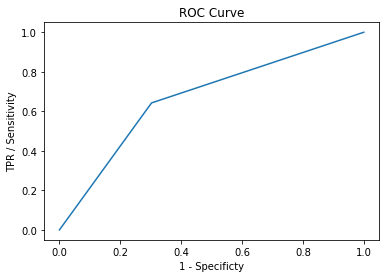

In [212]:
import matplotlib.pyplot as plt

sns.lineplot(fpr, tpr)
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')

In [213]:
log_loss(y_test, y_pred_proba)

3.989269901795787

In [214]:
auc(fpr, tpr)

0.6698994218999029

In [215]:
accuracy_score(y_test, y_pred)

0.6807610993657506

In [216]:
y_test.value_counts()

False    991
True     428
Name: target, dtype: int64

In [217]:
pd.Series(y_pred).value_counts()

False    844
True     575
dtype: int64